# Gaussian Process Regression and Bayesian Global Optimisation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.path as mpath
import boframework.gp as gp
import boframework.kernels as kernels
import boframework.acquisitions as acquisitions 
import boframework.bayesopt as bayesopt
import importlib
importlib.reload(gp)
importlib.reload(kernels)
importlib.reload(acquisitions)
importlib.reload(bayesopt)
%matplotlib inline

#### We want to maximise the following 1-dimensional function,
$$\mathrm{maximise}_x\quad f(x)$$
where
$$f(x) = \sin(x) + \sin(2x) + \epsilon$$


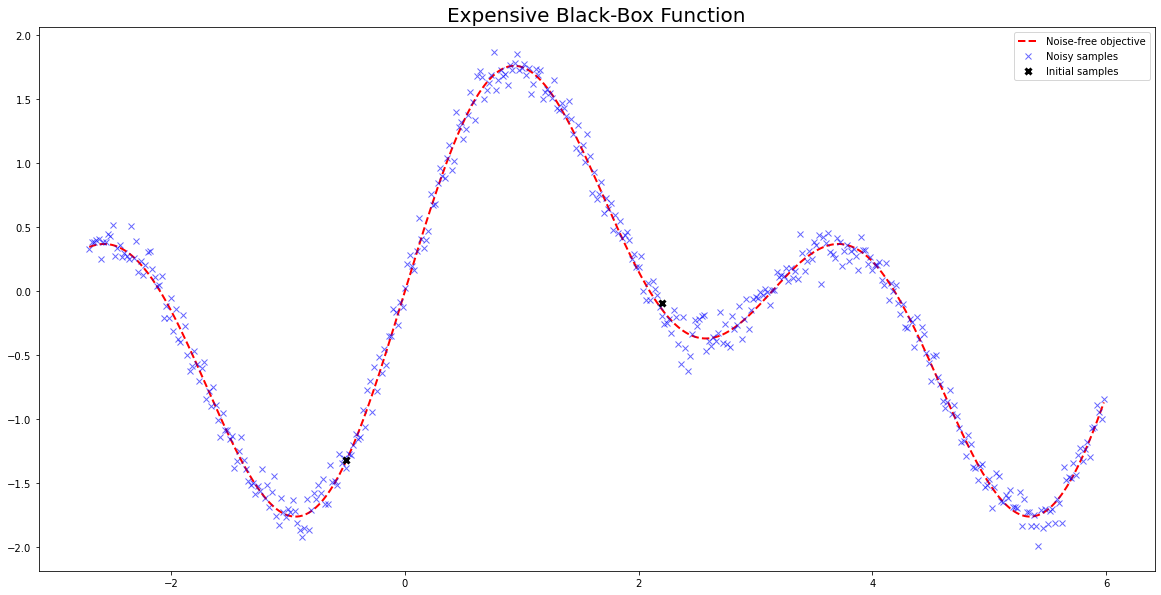

In [2]:
bounds = np.array([[-2.7, 6]])
noise_level = 0.1

np.random.seed(4)

def f(X, noise_level=noise_level):
    return np.sin(X) + np.sin(2 * X) + noise_level * np.random.randn(*X.shape)

X_init = np.array([[-0.5], [2.2]])
Y_init = f(X_init)

# Bound our random variable X
X = np.arange(bounds[:, 0], bounds[:, 1], 0.02).reshape(-1, 1)

# First let's have a noise-free objective function
Y = f(X, 0)

#Plot optimisation objective with the appropriate noise levels
plt.figure(figsize=(20, 10))
plt.plot(X, Y, 'r--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.6, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.title("Expensive Black-Box Function", fontdict = {'fontsize' : 20})
plt.legend()
plt.show()


In [3]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'r--', lw=2, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()
    plt.grid()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'g-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
    plt.grid()
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(20, 5))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    star = mpath.Path.unit_regular_star(6)
    circle = mpath.Path.unit_circle()
    # concatenate the circle with an internal cutout of the star
    verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
    codes = np.concatenate([circle.codes, star.codes])
    cut_star = mpath.Path(verts, codes)


    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, '--k', marker=cut_star, markersize=10)
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, '--c', marker=cut_star, markersize=10)
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')
    plt.grid()

In [4]:
bayes_opt = bayesopt.BO(X_init, Y_init, f, noise_level, bounds, X=X, Y=Y, plt_appr=plot_approximation, plt_acq=plot_acquisition)


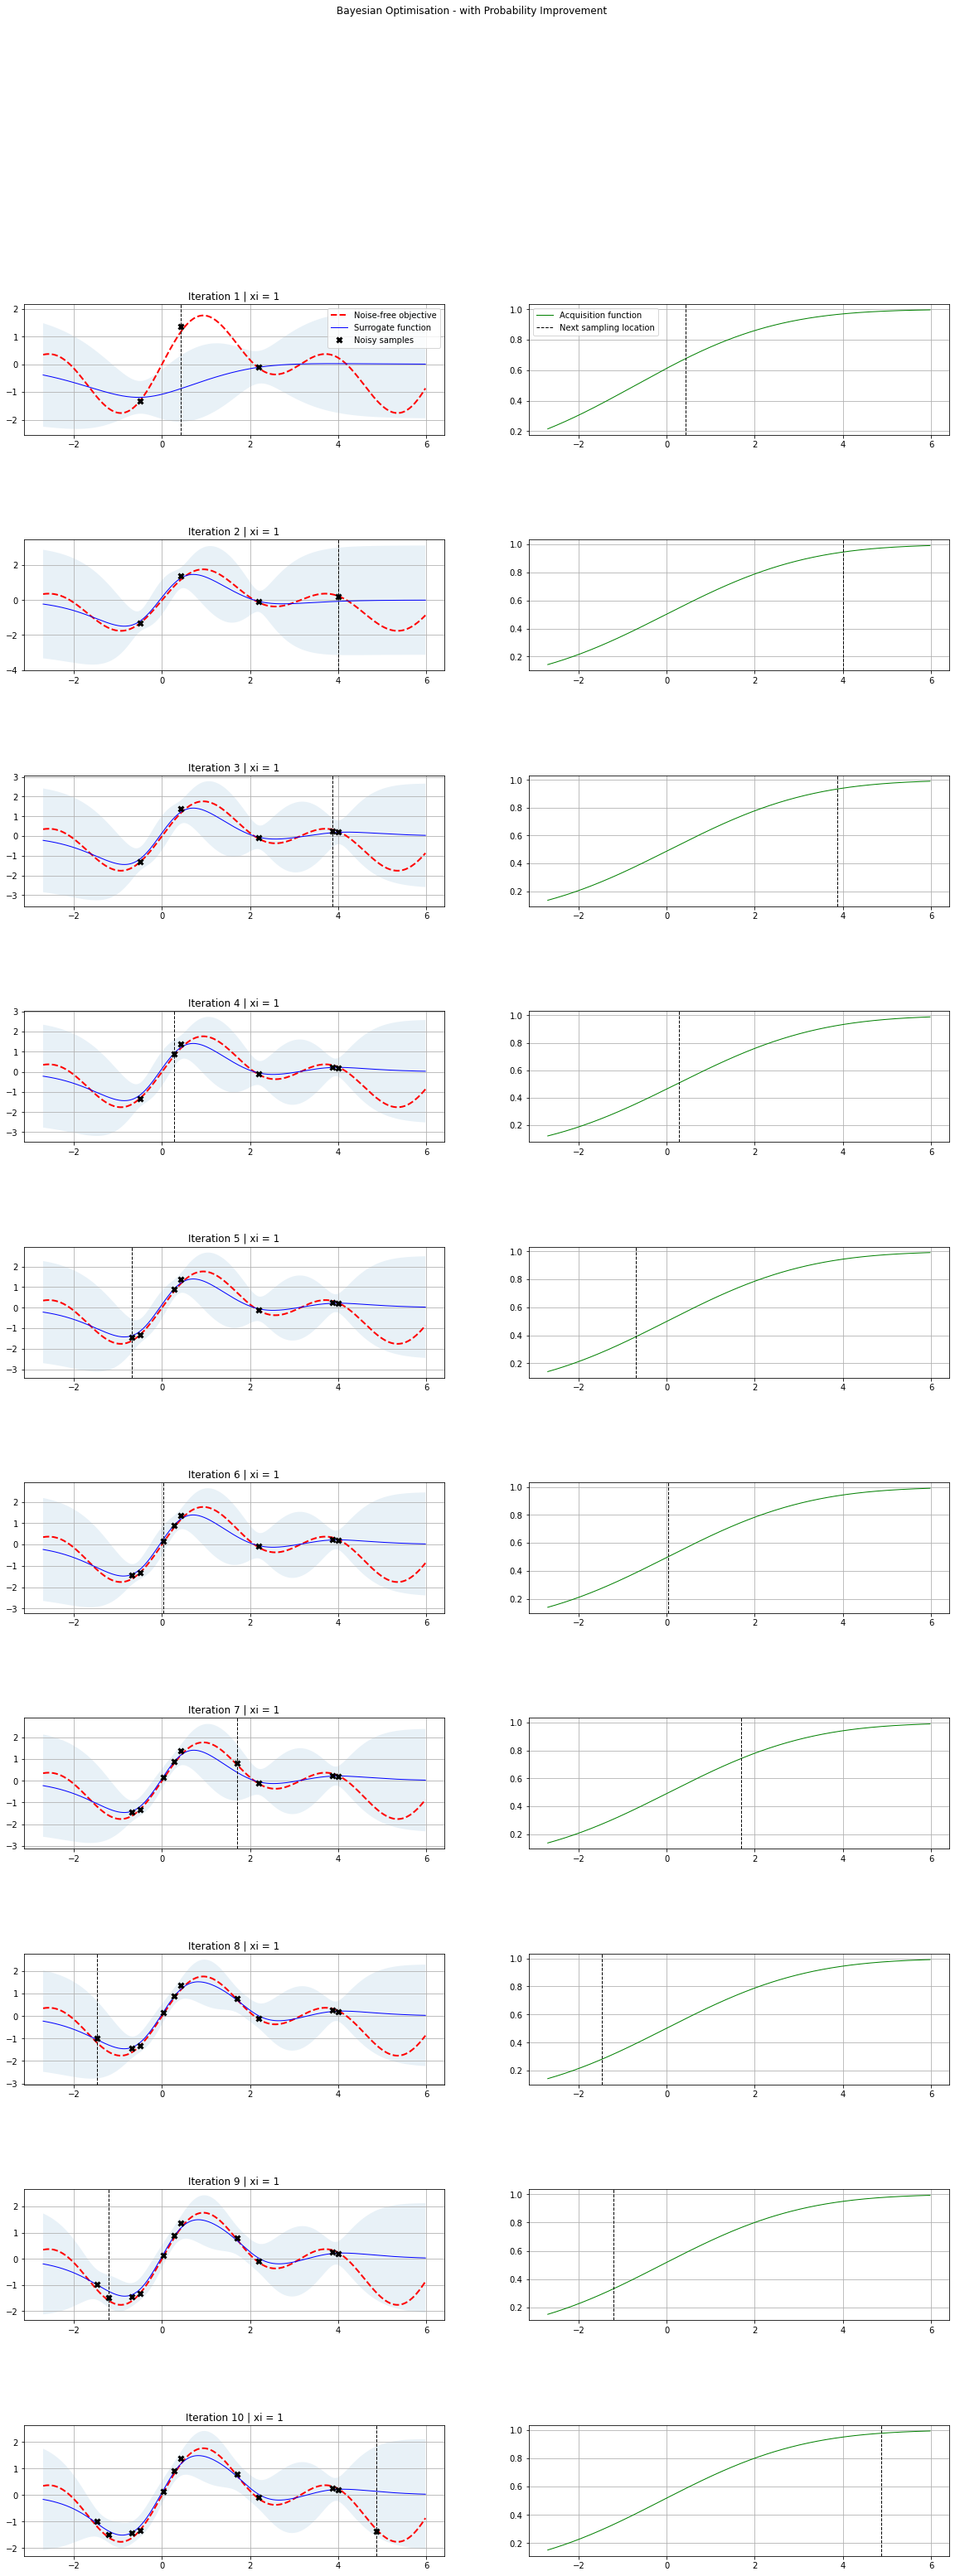

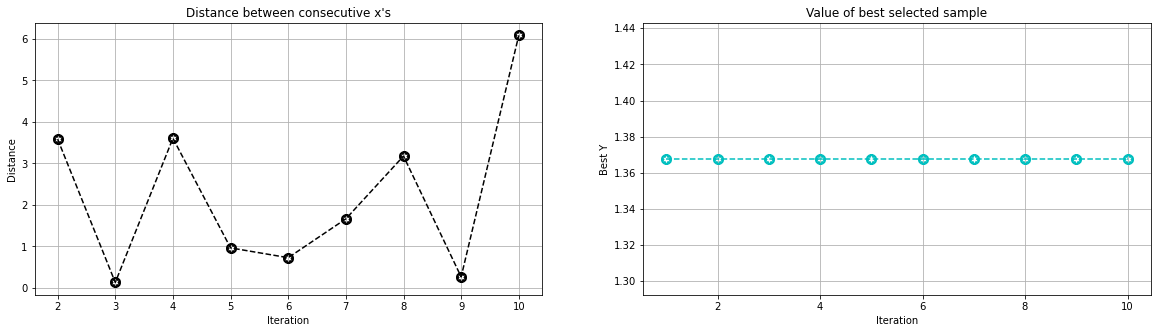

In [5]:
# Probability Improvement (PI)
xi = 1
X_sample, Y_sample = bayes_opt(acquisitions.probability_improvement, xi, 10, 'Bayesian Optimisation - with Probability Improvement')
plot_convergence(X_sample, Y_sample)

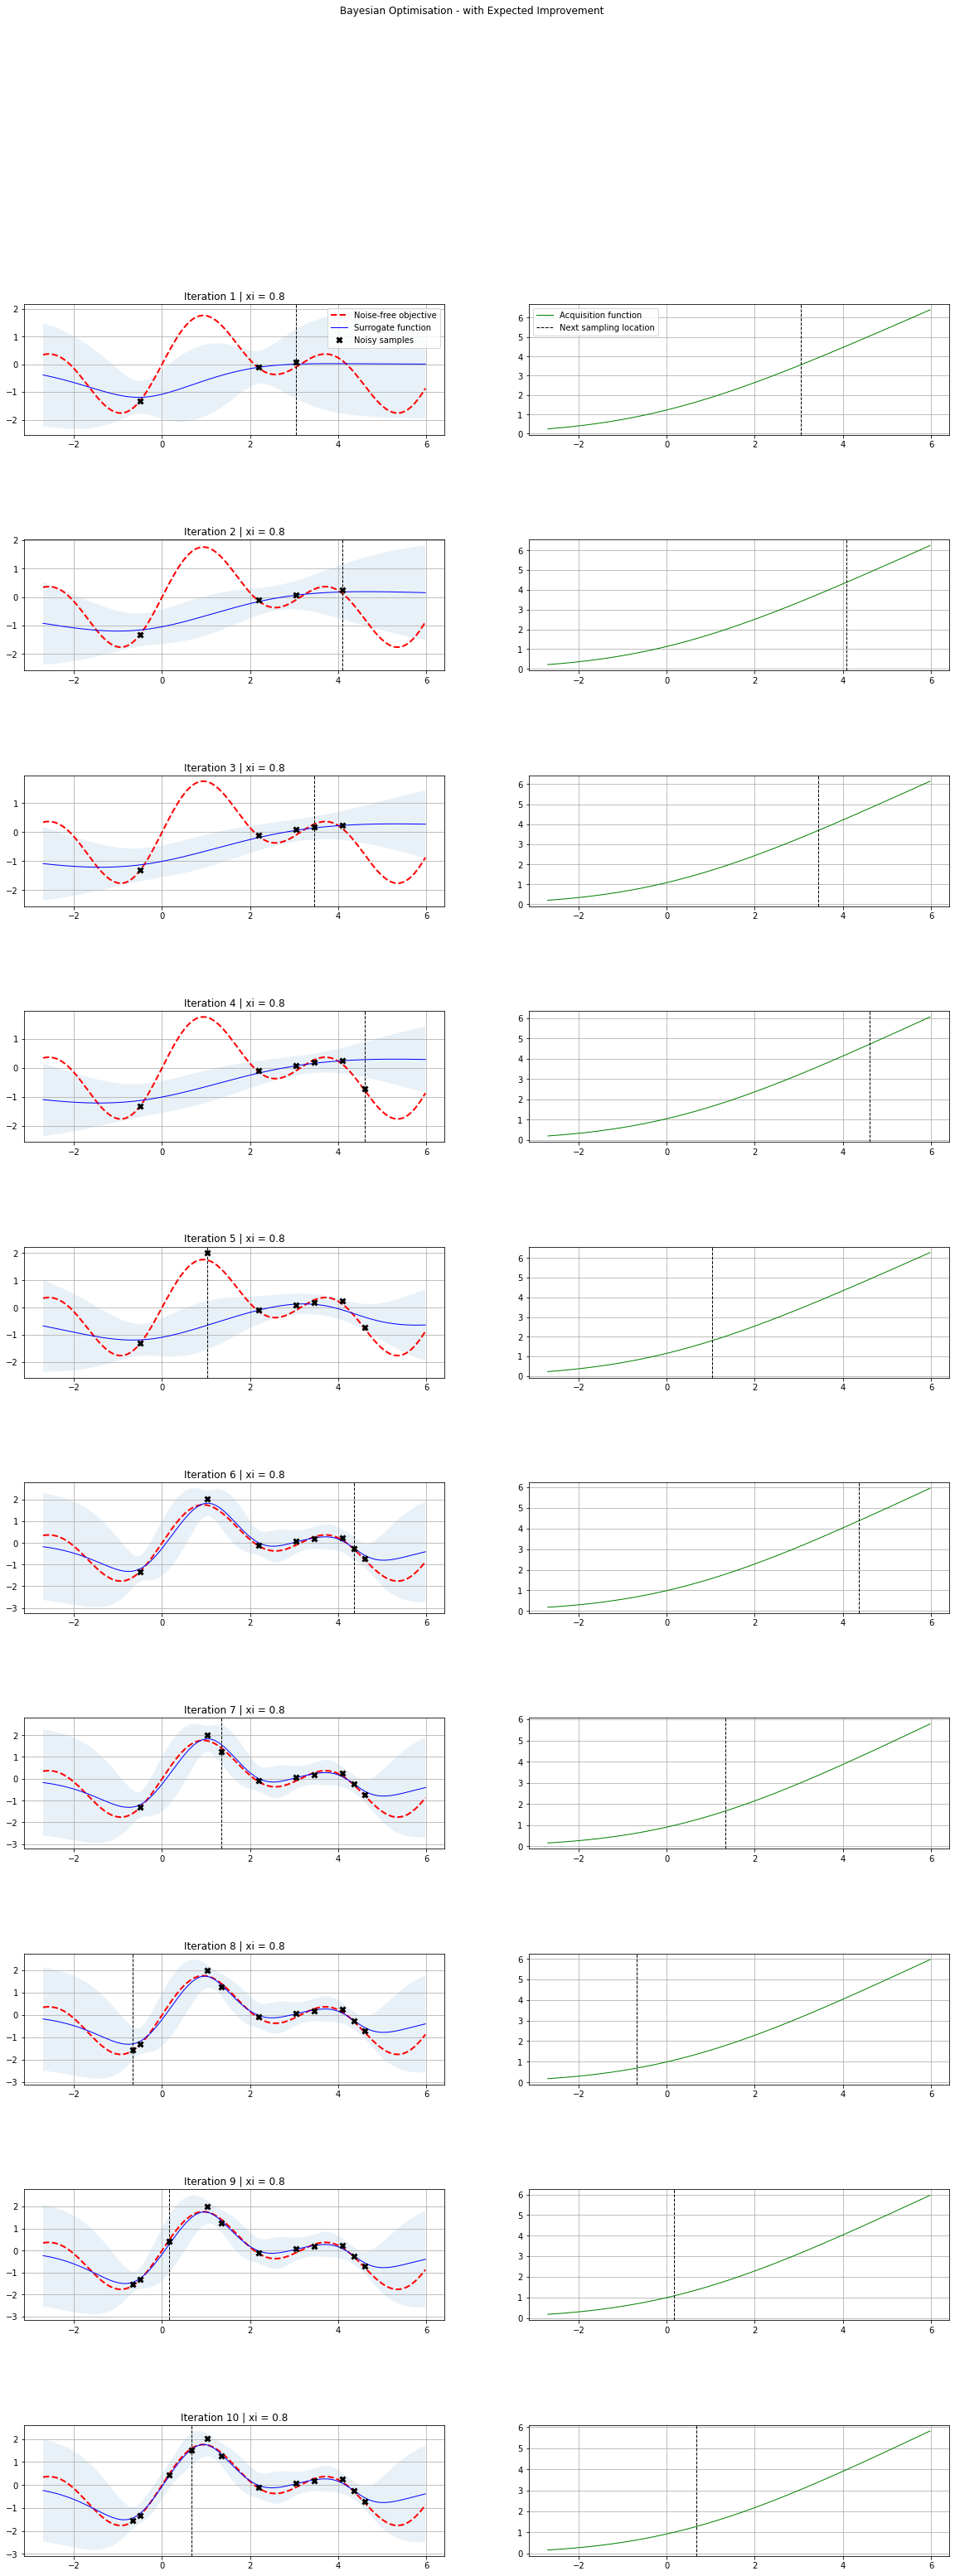

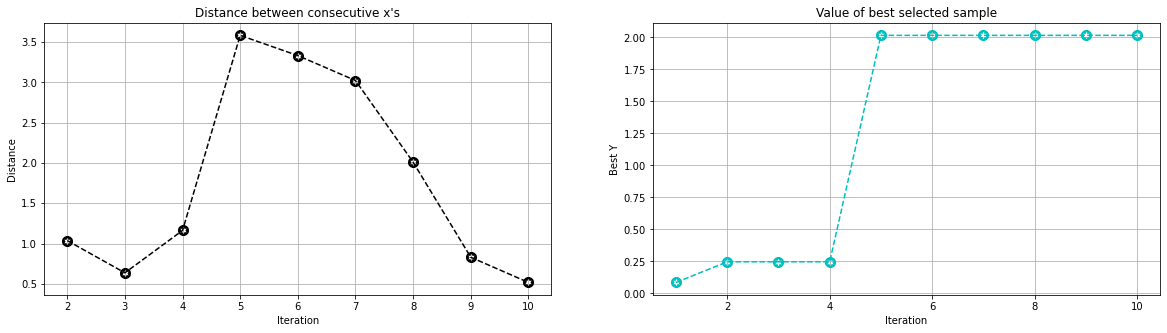

In [6]:
# Expected Improvement (EI)
xi = 0.8
X_sample, Y_sample = bayes_opt(acquisitions.expected_improvement, xi, 10, 'Bayesian Optimisation - with Expected Improvement')
plot_convergence(X_sample, Y_sample)

### Higher Dimensions

Let's assume that we want to approximate a higher dimensional function via the surrogate model, using a Gaussian Process regression.

We have the function of a N-dimensional dataset $X$, 
$$
f(X) = \sin^2\left(\frac{||X||_F}{2}\right) + \boldsymbol{\epsilon}
$$

where we take the Frobenius norm of $X$ per column (second dimension).

Let's now investigate the benefits of performing hyper-parameter optimisation on the Gaussian process regression model during the fitting process by maximising the log marginal likelihood, before performing tasks such as Bayesian optimisation to find global optima.

In [7]:
def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 3, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.bwr, linewidth=0.5, alpha=0.3, antialiased=False)
    ax.scatter(X_train[:,0], X_train[0:,1], Y_train, c=Y_train, cmap=cm.seismic)
    ax.set_title(title)

noise_2D = 0.1
np.random.seed(3408944656)

def f2D(X, noise_2D=noise_2D):
    return np.sin(0.5 * np.linalg.norm(X, axis=1))**2 + noise_2D * np.random.randn(len(X))

m52 = kernels.Matern(length_scale=1.0, variance=1.0, nu=2.5)
gpr = gp.GPRegressor(kernel=m52, noise_level=noise_2D**2, n_restarts=20)


rx, ry = np.arange(-10, 10, 0.1), np.arange(-10, 10, 0.1)
gx, gy = np.meshgrid(rx, rx)
X_2D = np.c_[gx.ravel(), gy.ravel()]

Y_2D = f2D(X_2D, 0)

X_2D_train = np.random.uniform(-8, 8, (100, 2))

Y_2D_train = f2D(X_2D_train)

plt.figure(figsize=(20,10))

mu_s = gpr.fit_and_predict(X_2D_train, Y_2D_train, X_2D)
plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train, f'Before hyper-parameter optimization: l={1.00} sigma^2_f={1.00}', 1)

params, mu_s = gpr.fit_and_predict(X_2D_train, Y_2D_train, X_2D, optimise_fit=True)
for key in sorted(params): print(f"{key} : {params[key]}")

plot_gp_2D(gx, gy, mu_s, X_2D_train, Y_2D_train,
           f'After hyper-parameter optimization: l={params["length_scale"]:.2f} sigma^2_f={params["variance"]:.2f}', 2)

plot_gp_2D(gx, gy, Y_2D, X_2D_train, Y_2D_train, f'Original function without noise', 3)

NotImplementedError: 

<Figure size 1440x720 with 0 Axes>